# Train-Test similarity binning

In [1]:
# Retina quality plots
%config InlineBackend.figure_format = 'retina'

## Load data

In [2]:
import pandas as pd

part0 = pd.read_parquet('../../data/train_test_alignments/alignments_cdr3_part0.parquet')

part0.info()
part0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57594 entries, 0 to 57593
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Source_Seq  57594 non-null  object 
 1   Target_Seq  57594 non-null  object 
 2   Score       55723 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.3+ MB


,Source_Seq,Target_Seq,Score
0,AKD-PVEVATLFPHQDDVTNWFDP,AKDRPTQWA-LVPHR--V-GWLDP,50.0
1,AKDMRREGILRTMIRGVSCWFDP,ARD-SRSG--RTTVWGVTNWFDP,57.0
2,ARVAAKESWGNTILGVVSNWFDP,ARVAAKESWGNTILGVVSNWFDP,NaN
3,ARDGYAFRFLEWLERARRNWLDP,ARVG-GVRFLEWLPRG--NWFDP,68.0
4,ARGRRGRYDFVTGY-RADQGWFDP,ARGRRGKYDFLTGYTKGLYNYFDP,84.0


In [3]:
import pandas as pd

part1 = pd.read_parquet('../../data/train_test_alignments/alignments_cdr3_part1.parquet')

part1.info()
part1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57595 entries, 0 to 57594
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Source_Seq  57595 non-null  object 
 1   Target_Seq  57595 non-null  object 
 2   Score       57113 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.3+ MB


,Source_Seq,Target_Seq,Score
0,ARD-LSRTIDSAY,ARDRYSRNLDAEY,33.0
1,AKAR--WDIGRFDY,AKARSYWGIG-FDY,45.0
2,VREAPGGDLFKY,ARD-PGGEYFDY,34.0
3,VRKGP--WSYLFNY,VREAPSGW-YYFDY,36.0
4,V---GAAPWSYRFKY,AKGPGSAPFNYRFDH,30.0


In [4]:
alignments = pd.concat([part0, part1]).reset_index(drop=True)

alignments.info()
alignments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115189 entries, 0 to 115188
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Source_Seq  115189 non-null  object 
 1   Target_Seq  115189 non-null  object 
 2   Score       112836 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.6+ MB


,Source_Seq,Target_Seq,Score
0,AKD-PVEVATLFPHQDDVTNWFDP,AKDRPTQWA-LVPHR--V-GWLDP,50.0
1,AKDMRREGILRTMIRGVSCWFDP,ARD-SRSG--RTTVWGVTNWFDP,57.0
2,ARVAAKESWGNTILGVVSNWFDP,ARVAAKESWGNTILGVVSNWFDP,NaN
3,ARDGYAFRFLEWLERARRNWLDP,ARVG-GVRFLEWLPRG--NWFDP,68.0
4,ARGRRGRYDFVTGY-RADQGWFDP,ARGRRGKYDFLTGYTKGLYNYFDP,84.0


## Alignments overview

In [6]:
# NaN score means identical sequences
alignments['Score'].isnull().value_counts()

False    112836
True       2353
Name: Score, dtype: int64

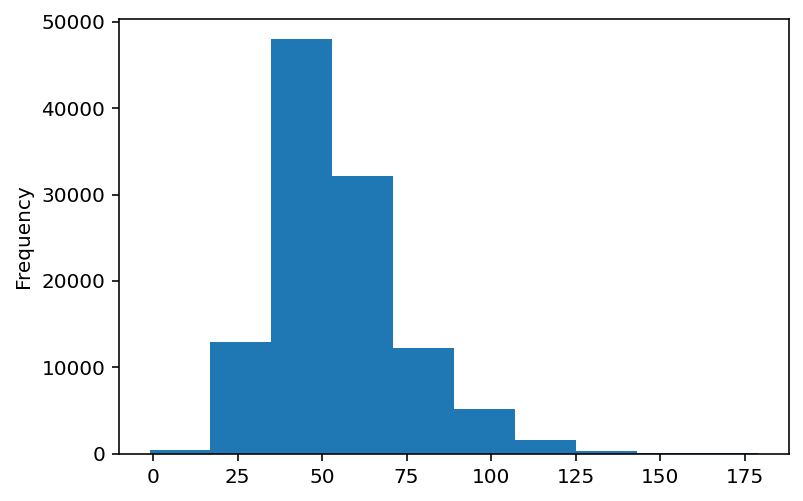

In [7]:
alignments['Score'].plot.hist();

## Sequences identity and similarity

### Gap-excluded identity

In [8]:
GAP_CHAR = '-'

def identity(seq1, seq2, compute_identity, aa_match=lambda aa1, aa2: aa1 == aa2):
    aa_list1 = list(seq1)
    aa_list2 = list(seq2)
    
    aa_list1_len = len(aa_list1)
    assert aa_list1_len == len(aa_list2)
    
    omit1 = [i for i, aa in enumerate(aa_list1) if aa == GAP_CHAR]
    omit2 = [i for i, aa in enumerate(aa_list2) if aa == GAP_CHAR]
    
    extending_gap_indices = []
    
    for gaps_indices in [omit1, omit2]:
        prev_gap_index = -10
        for gap_idx in gaps_indices:
            if gap_idx == prev_gap_index + 1:
                extending_gap_indices.append(gap_idx)

            prev_gap_index = gap_idx
    
    extending_gaps_cnt = len(set(extending_gap_indices))
    
    matching_cnt = 0
    gaps_cnt = 0
    for i in range(aa_list1_len):
        if i not in omit1 and i not in omit2:
            matching_cnt += aa_match(aa_list1[i], aa_list2[i])
        else:
            gaps_cnt += 1
    
    return compute_identity(matching_cnt, aa_list1_len, gaps_cnt, extending_gaps_cnt)

In [9]:
def compute_gap_excluded_identity(matching_cnt, alignment_len, gaps_cnt, extending_gaps_cnt):
    return matching_cnt / (alignment_len - gaps_cnt)

def gap_excluded_identity(seq1, seq2):
    return identity(seq1, seq2, compute_gap_excluded_identity)

In [10]:
gap_excl_identity = alignments.apply(lambda row: 1 if pd.isnull(row['Score']) else gap_excluded_identity(row['Source_Seq'], row['Target_Seq']), axis=1)
gap_excl_identity

0         0.631579
1         0.600000
2         1.000000
3         0.700000
4         0.652174
            ...   
115184    0.625000
115185    0.750000
115186    0.500000
115187    0.714286
115188    0.800000
Length: 115189, dtype: float64

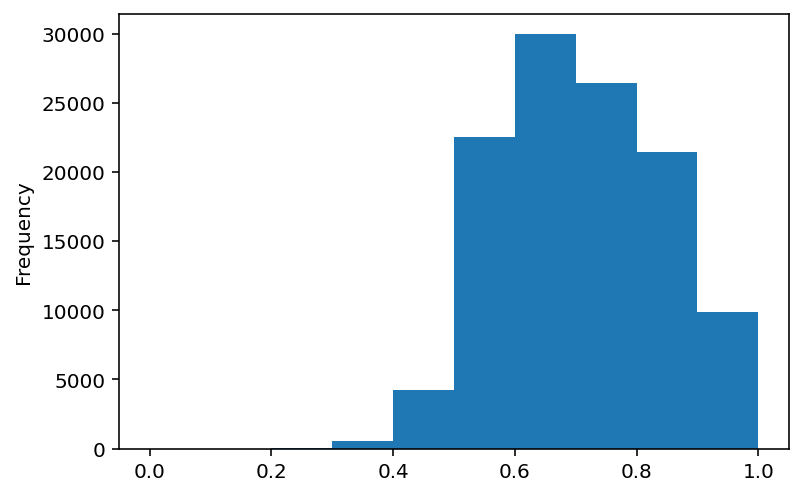

In [11]:
gap_excl_identity.plot.hist();

### BLAST identity

In [12]:
def compute_blast_identity(matching_cnt, alignment_len, gaps_cnt, extending_gaps_cnt):
    return matching_cnt / alignment_len

def blast_identity(seq1, seq2):
    return identity(seq1, seq2, compute_blast_identity)

In [13]:
blast_identity_vals = alignments.apply(lambda row: 1 if pd.isnull(row['Score']) else blast_identity(row['Source_Seq'], row['Target_Seq']), axis=1)
blast_identity_vals

0         0.500000
1         0.521739
2         1.000000
3         0.608696
4         0.625000
            ...   
115184    0.625000
115185    0.750000
115186    0.500000
115187    0.555556
115188    0.800000
Length: 115189, dtype: float64

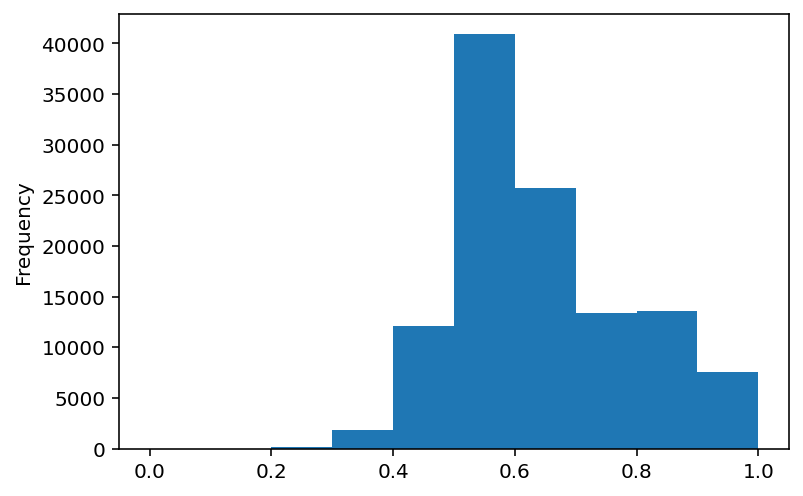

In [14]:
blast_identity_vals.plot.hist();

### BLAST similarity

In [15]:
from Bio.SubsMat import MatrixInfo as matlist

SUBST_MATRIX = matlist.blosum62

def similarity_aa_match(aa1, aa2):
    if (aa1, aa2) in SUBST_MATRIX:
        return SUBST_MATRIX[(aa1, aa2)] > 0
    
    return SUBST_MATRIX[(aa2, aa1)] > 0

def blast_similarity(seq1, seq2):
    return identity(seq1, seq2, compute_blast_identity, similarity_aa_match)

In [16]:
blast_similarity_vals = alignments.apply(lambda row: 1 if pd.isnull(row['Score']) else blast_similarity(row['Source_Seq'], row['Target_Seq']), axis=1)
blast_similarity_vals

0         0.583333
1         0.652174
2         1.000000
3         0.608696
4         0.791667
            ...   
115184    0.625000
115185    0.875000
115186    0.500000
115187    0.722222
115188    0.800000
Length: 115189, dtype: float64

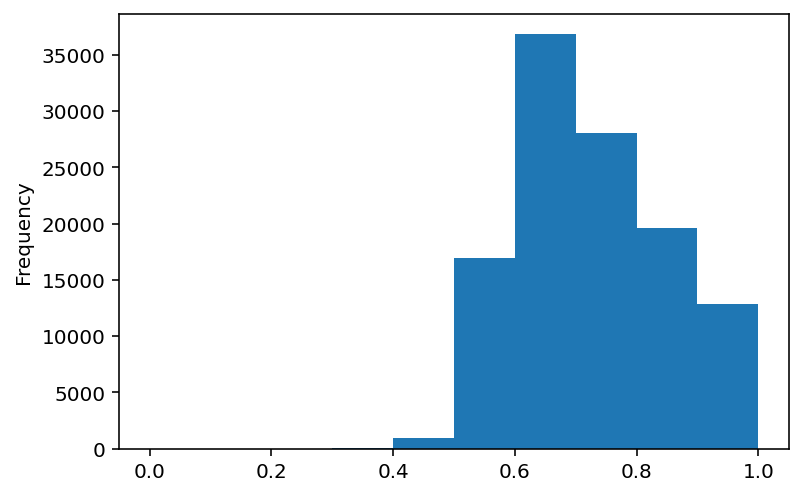

In [17]:
blast_similarity_vals.plot.hist();

### Gap-compressed identity

In [18]:
def compute_gap_compressed_identity(matching_cnt, alignment_len, gaps_cnt, extending_gaps_cnt):
    return matching_cnt / (alignment_len - extending_gaps_cnt)

def gap_compressed_identity(seq1, seq2):
    return identity(seq1, seq2, compute_gap_compressed_identity)

In [19]:
gap_compressed_identity_vals = alignments.apply(lambda row: 1 if pd.isnull(row['Score']) else gap_compressed_identity(row['Source_Seq'], row['Target_Seq']), axis=1)
gap_compressed_identity_vals

0         0.521739
1         0.545455
2         1.000000
3         0.636364
4         0.625000
            ...   
115184    0.625000
115185    0.750000
115186    0.500000
115187    0.588235
115188    0.800000
Length: 115189, dtype: float64

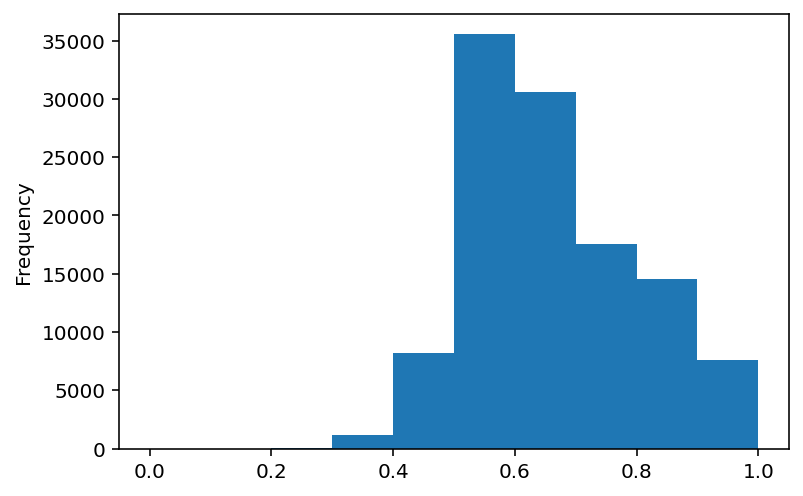

In [20]:
gap_compressed_identity_vals.plot.hist();

## Comparison

In [21]:
comp_df = pd.DataFrame({'Gap-excluded identity': gap_excl_identity, 
                         'BLAST identity': blast_identity_vals,
                         'BLAST similarity': blast_similarity_vals,
                         'Gap-compressed identity': gap_compressed_identity_vals})

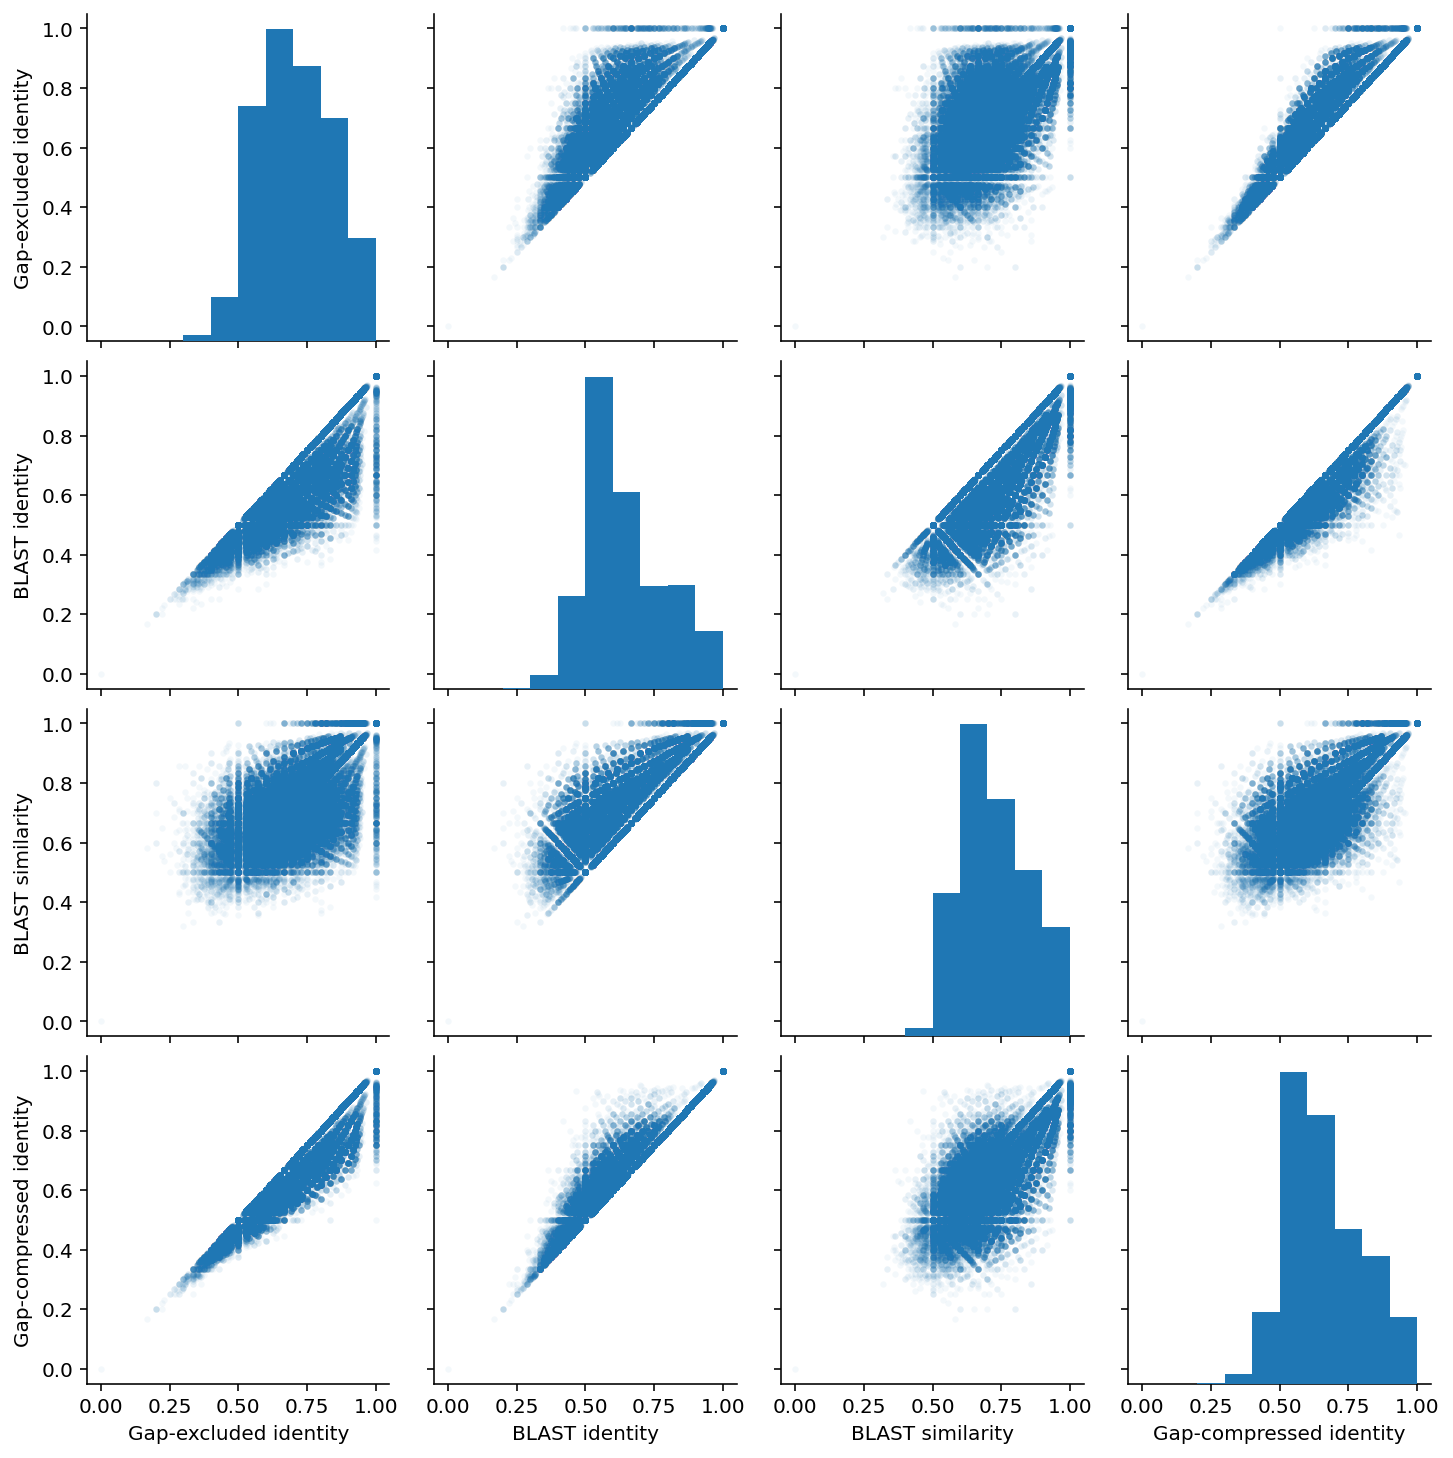

In [22]:
import seaborn as sns

sns.pairplot(comp_df, plot_kws={'s': 10, 'linewidth': 0, 'alpha': 0.05});

## Binning

In [23]:
source_seqs = alignments['Source_Seq'].apply(lambda seq: seq.replace(GAP_CHAR, ''))
source_seqs

0         AKDPVEVATLFPHQDDVTNWFDP
1         AKDMRREGILRTMIRGVSCWFDP
2         ARVAAKESWGNTILGVVSNWFDP
3         ARDGYAFRFLEWLERARRNWLDP
4         ARGRRGRYDFVTGYRADQGWFDP
                   ...           
115184                   VRDKSADY
115185                   ARDNSADY
115186             AREHQIETAGSGDW
115187             ARVDGSGANSYWAY
115188                 VKAPNWEADC
Name: Source_Seq, Length: 115189, dtype: object

In [24]:
scores_df = pd.DataFrame({'CDR3': source_seqs,
                          'BLAST identity': blast_identity_vals,
                          'BLAST similarity': blast_similarity_vals})

scores_df.head()

,CDR3,BLAST identity,BLAST similarity
0,AKDPVEVATLFPHQDDVTNWFDP,0.500000,0.583333
1,AKDMRREGILRTMIRGVSCWFDP,0.521739,0.652174
2,ARVAAKESWGNTILGVVSNWFDP,1.000000,1.000000
3,ARDGYAFRFLEWLERARRNWLDP,0.608696,0.608696
4,ARGRRGRYDFVTGYRADQGWFDP,0.625000,0.791667


In [25]:
test_pos_seqs = pd.read_parquet('../../data/train_test_alignments/Galson_2016_pos.parquet')

test_pos_seqs.info()
test_pos_seqs.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229352 entries, 0 to 1682426
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   num_errors     229352 non-null  object
 1   redundancy     229352 non-null  int64 
 2   name           229352 non-null  int64 
 3   seq            229352 non-null  object
 4   v              229352 non-null  object
 5   cdr3           229352 non-null  object
 6   original_name  229352 non-null  object
 7   errors         229352 non-null  object
 8   j              229352 non-null  object
 9   data           229352 non-null  object
 10  Longitudinal   229352 non-null  object
 11  Chain          229352 non-null  object
 12  Author         229352 non-null  object
 13  Isotype        229352 non-null  object
 14  Age            229352 non-null  object
 15  Size_igblastn  229352 non-null  int64 
 16  Disease        229352 non-null  object
 17  Link           229352 non-null  object
 18  BSo

,num_errors,redundancy,name,seq,v,cdr3,original_name,errors,j,data,...,Disease,Link,BSource,BType,Subject,Species,Vaccine,Size,cdr3_len,Cluster_ID
0,0,1,63311,SLRLSCAASGFIFSSYVMSWVRQAPGKGLEWVSAIIGSGGTTFYAD...,IGHV3-23*01,AKDPVEVATLFPHQDDVTNWFDP,108143,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2492,human,HepB,231143,23,0
4,0,1,25941,SLRLSCAGSGFTFSSFAMSWVRQAPGKGLEWVSAISASGASTYYAD...,IGHV3-23*01,AKDMRREGILRTMIRGVSCWFDP,86341,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""G"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2277,human,HepB,121330,23,4
5,1,1,15602,SLRLSCAASGFTFSSDCMTWVRQTPGKGLEWVSAISTGGDHRYYAD...,IGHV3-23*01,ARVAAKESWGNTILGVVSNWFDP,129456,"[('96', 'L')]",IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2277,human,HepB,174101,23,5
10,0,1,32896,SLRLSCAASGFTFSSYAMTWVRQAPGKGLEWVSAISGSGGTTYYAD...,IGHV3-23*01,ARDGYAFRFLEWLERARRNWLDP,148414,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2752,human,HepB,204878,23,10
14,0,1,18065,SLRLSCAASGFRSTTYATSWVRQAPGKGLEWVSGISGSAESARYAD...,IGHV3-23*01,ARGRRGRYDFVTGYRADQGWFDP,117589,[None],IGHJ5*02,"{""fwh1"": {""24"": ""A"", ""25"": ""A"", ""26"": ""S"", ""20...",...,None,https://genomemedicine.biomedcentral.com/artic...,PBMC,HepB+B-cells,Subject-2954,human,HepB,198880,23,14


In [ ]:
def bin_seqs(thresholds, score_col, test_seqs=test_pos_seqs, scores_df=scores_df):
    cdr3_bins = []
    curr_scores_df = scores_df
    
    for threshold in thresholds:
        to_bin_mask = curr_scores_df[score_col] <= threshold
        bin_cdr3_seqs = curr_scores_df[to_bin_mask]['CDR3']
        
        cdr3_bins.append(test_seqs[test_seqs['cdr3'].isin(bin_cdr3_seqs)])
        curr_scores_df = curr_scores_df.drop(curr_scores_df[to_bin_mask].index)
    
    return cdr3_bins

In [ ]:
BIN_THRESHOLDS = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

identity_bins = bin_seqs(BIN_THRESHOLDS, 'BLAST identity')
identity_bin_sizes = [len(identity_bin) for identity_bin in identity_bins]
identity_bin_sizes

In [ ]:
sum(identity_bin_sizes) == len(test_pos_seqs)

In [ ]:
for seq_bin, threshold in zip(identity_bins, BIN_THRESHOLDS):
    seq_bin.to_parquet(f'../../data/train_test_alignments/Galson_2016_pos_{int(threshold * 100)}_identity.parquet')

In [ ]:
sim_bins = bin_seqs(BIN_THRESHOLDS, 'BLAST similarity')
sim_bin_sizes = [len(sim_bin) for sim_bin in sim_bins]
sim_bin_sizes

In [ ]:
sum(sim_bin_sizes) == len(test_pos_seqs)

In [ ]:
for seq_bin, threshold in zip(sim_bins, BIN_THRESHOLDS):
    seq_bin.to_parquet(f'../../data/train_test_alignments/Galson_2016_pos_{int(threshold * 100)}_sim.parquet')

### Fingerprints

In [26]:
import pandas as pd

fps = pd.read_parquet('../../data/features_data_g2016/fingerprints_cdr3/Circular.parquet')

fps.info()
fps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682432 entries, 0 to 1682431
Columns: 512 entries, 0 to 511
dtypes: bool(512)
memory usage: 821.5 MB


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,True,True,False,False,True,True,True,False,True,False,...,False,True,True,False,True,True,True,True,True,False
1,True,True,False,True,True,True,True,True,False,True,...,False,False,True,True,True,True,True,True,True,False
2,True,True,False,True,True,True,True,False,True,True,...,False,True,True,False,True,True,True,True,True,False
3,True,True,False,True,True,True,True,True,True,True,...,False,True,True,False,True,True,True,True,True,True
4,True,True,False,True,True,False,True,True,True,False,...,True,True,True,False,True,True,True,True,True,False


In [27]:
def bin_seqs(thresholds, score_col, test_seqs, scores_df=scores_df):
    cdr3_bins = []
    curr_scores_df = scores_df
    
    for threshold in thresholds:
        to_bin_mask = curr_scores_df[score_col] <= threshold
        bin_cdr3_seqs = curr_scores_df[to_bin_mask]['CDR3']
        
        cdr3_bins.append(test_seqs.loc[test_pos_seqs.index[test_pos_seqs['cdr3'].isin(bin_cdr3_seqs)]])
        curr_scores_df = curr_scores_df.drop(curr_scores_df[to_bin_mask].index)
    
    return cdr3_bins

In [28]:
BIN_THRESHOLDS = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

identity_bins = bin_seqs(BIN_THRESHOLDS, 'BLAST identity', fps)
identity_bin_sizes = [len(identity_bin) for identity_bin in identity_bins]
identity_bin_sizes

[34955, 64535, 57229, 27517, 14247, 30869]

In [29]:
for seq_bin, threshold in zip(identity_bins, BIN_THRESHOLDS):
    seq_bin.to_parquet(f'../../data/train_test_alignments/fps_Galson_2016_pos_{int(threshold * 100)}_identity.parquet')

In [30]:
sim_bins = bin_seqs(BIN_THRESHOLDS, 'BLAST similarity', fps)
sim_bin_sizes = [len(sim_bin) for sim_bin in sim_bins]
sim_bin_sizes

[3439, 25751, 70692, 65908, 26724, 36838]

In [31]:
for seq_bin, threshold in zip(sim_bins, BIN_THRESHOLDS):
    seq_bin.to_parquet(f'../../data/train_test_alignments/fps_Galson_2016_pos_{int(threshold * 100)}_sim.parquet')

### k-mers

In [57]:
import pandas as pd

kmers = pd.read_parquet('../../data/features_data_g2016/kmers_cdr3/Galson_2016_single.parquet')

kmers.info()
kmers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682432 entries, 0 to 1682431
Columns: 8000 entries, AAA to YYY
dtypes: uint16(8000)
memory usage: 25.1 GB


,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYM,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
def bin_seqs(thresholds, score_col, test_seqs, scores_df=scores_df):
    cdr3_bins = []
    curr_scores_df = scores_df
    
    for threshold in thresholds:
        to_bin_mask = curr_scores_df[score_col] <= threshold
        bin_cdr3_seqs = curr_scores_df[to_bin_mask]['CDR3']
        
        cdr3_bins.append(test_seqs.loc[test_pos_seqs.index[test_pos_seqs['cdr3'].isin(bin_cdr3_seqs)]])
        curr_scores_df = curr_scores_df.drop(curr_scores_df[to_bin_mask].index)
    
    return cdr3_bins

In [59]:
BIN_THRESHOLDS = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

identity_bins = bin_seqs(BIN_THRESHOLDS, 'BLAST identity', kmers)
identity_bin_sizes = [len(identity_bin) for identity_bin in identity_bins]
identity_bin_sizes

[34955, 64535, 57229, 27517, 14247, 30869]

In [60]:
for seq_bin, threshold in zip(identity_bins, BIN_THRESHOLDS):
    seq_bin.to_parquet(f'../../data/train_test_alignments/kmers_Galson_2016_pos_{int(threshold * 100)}_identity.parquet')

In [61]:
sim_bins = bin_seqs(BIN_THRESHOLDS, 'BLAST similarity', kmers)
sim_bin_sizes = [len(sim_bin) for sim_bin in sim_bins]
sim_bin_sizes

[3439, 25751, 70692, 65908, 26724, 36838]

In [62]:
for seq_bin, threshold in zip(sim_bins, BIN_THRESHOLDS):
    seq_bin.to_parquet(f'../../data/train_test_alignments/kmers_Galson_2016_pos_{int(threshold * 100)}_sim.parquet')